Using keras to apply gradient ascent and try to understand what each layer of the ml algorithm is detecting
https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [2]:
import os
import gc
import sys
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
%matplotlib inline

2022-12-07 15:54:35.726920: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-07 15:54:35.774024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 15:54:35.774043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
with open("data/pickle/data", 'rb') as file:
    var = pickle.load(file=file)
    test_x_sorted    = var["train_x_data"][:]
    test_y_sorted    = var["train_y_data"][:]
    freq             = var["freq"][:]

In [4]:
model = load_model("ml_models/cnn_2022_7_20_fpe.h5")
fbins = np.array([4000*1.0445**i for i in range(96)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 8)             40        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 16)            528       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 8)                 1

2022-12-07 15:54:37.344232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 15:54:37.344245: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 15:54:37.344258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-12-07 15:54:37.344593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Create smaller model
small_model = Sequential()
small_model.add(model.get_layer(name="conv1d"))
small_model.add(model.get_layer(name="max_pooling1d"))
small_model.add(model.get_layer(name="conv1d_1"))
small_model.add(model.get_layer(name="max_pooling1d_1"))
small_model.add(model.get_layer(name="flatten"))
small_model.add(model.get_layer(name="dense"))
small_model.add(model.get_layer(name="dense_1"))
small_model.add(model.get_layer(name="dense_2"))
#small_model.summary()

In [6]:
pred_y = small_model.predict(test_x_sorted)

14224/14224 [==============================] - 8s 517us/step


In [7]:
layer = model.get_layer(name="dense_3")
#feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
weights = np.array(layer.get_weights())[0]
print((weights))


[[0.06760126]
 [0.05066645]
 [0.04403219]
 [0.3311286 ]]


/tmp/ipykernel_300017/2012344097.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights = np.array(layer.get_weights())[0]


### Figured out that the 4th neuron is most important!!!

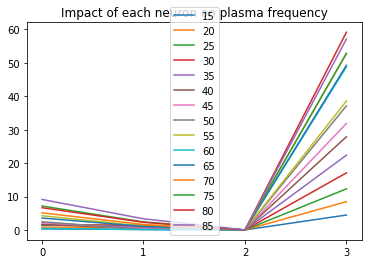

In [8]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])

fig, ax = plt.subplots()
ax.set_title("Impact of each neuron on plasma frequency")
for num in range(10,100,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        ax.plot(np.multiply(np.mean([pred_y[i] for i in index], axis=0),model.get_layer(name="dense_3").get_weights()[0][:,0])*50,label=num)
#ax.set_xscale(0,1)
ax.set_xticks([0,1,2,3])
ax.legend()
plt.show()

### Looking into 3rd neuron

In [9]:
print(model.get_layer(name="dense_2").get_weights()[0][:,3])

[-0.11729671 -0.8348653  -0.33504546  0.35629386  0.5139284   0.3275313
 -0.20624922  0.6270343 ]


In [10]:
small_model = Sequential()
small_model.add(model.get_layer(name="conv1d"))
small_model.add(model.get_layer(name="max_pooling1d"))
small_model.add(model.get_layer(name="conv1d_1"))
small_model.add(model.get_layer(name="max_pooling1d_1"))
small_model.add(model.get_layer(name="flatten"))
small_model.add(model.get_layer(name="dense"))
small_model.add(model.get_layer(name="dense_1"))
pred_y = small_model.predict(test_x_sorted)

14224/14224 [==============================] - 8s 539us/step


In [11]:
np.shape(pred_y)

(455153, 8)

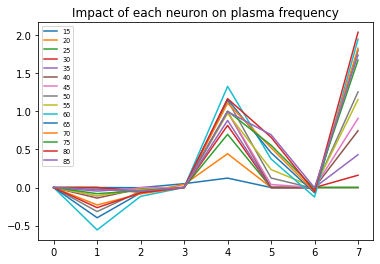

In [12]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])

fig, ax = plt.subplots()
ax.set_title("Impact of each neuron on plasma frequency")
for num in range(10,100,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        ax.plot(np.multiply(np.mean([pred_y[i] for i in index], axis=0),model.get_layer(name="dense_2").get_weights()[0][:,3]),label=num)
#ax.set_xscale(0,1)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.legend(prop={'size': 6.5})
plt.show()

In [13]:
# from this graph above, I am guessing that neuron 1 is responsible for causing midrange plasma frequencies to decrease
# neuron 4 and 7 is responsible for giving most of the value to the plasma frequency

### Looking into 2nd neuron

In [14]:
print(model.get_layer(name="dense_1").get_weights()[0][:,1])
print(model.get_layer(name="dense_1").get_weights()[0][:,4])
print(model.get_layer(name="dense_1").get_weights()[0][:,7])

[-0.4738883   0.457516   -0.13924879  0.05545086 -0.01470877  0.6074247
 -0.06130167 -0.24735315]
[ 0.04405317  0.7089924   0.11950745  0.46761116  0.19999285  0.65624267
 -0.18446155  0.20299676]
[ 0.06213399 -0.05175472  0.29583776 -0.14527519 -0.39557183  1.0671651
 -0.20328274 -0.22825527]


In [15]:
small_model = Sequential()
small_model.add(model.get_layer(name="conv1d"))
small_model.add(model.get_layer(name="max_pooling1d"))
small_model.add(model.get_layer(name="conv1d_1"))
small_model.add(model.get_layer(name="max_pooling1d_1"))
small_model.add(model.get_layer(name="flatten"))
small_model.add(model.get_layer(name="dense"))
pred_y = small_model.predict(test_x_sorted)

14224/14224 [==============================] - 7s 511us/step


In [16]:
np.shape(pred_y)

(455153, 8)

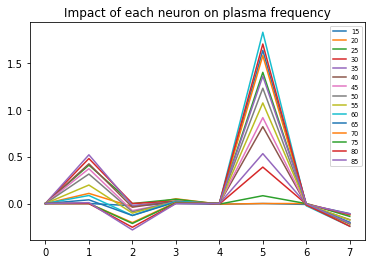

In [17]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])

fig, ax = plt.subplots()
ax.set_title("Impact of each neuron on plasma frequency")
for num in range(10,100,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        ax.plot(np.multiply(np.mean([pred_y[i] for i in index], axis=0),model.get_layer(name="dense_1").get_weights()[0][:,1]),label=num)
#ax.set_xscale(0,1)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.legend(prop={'size': 6.5})
plt.show()

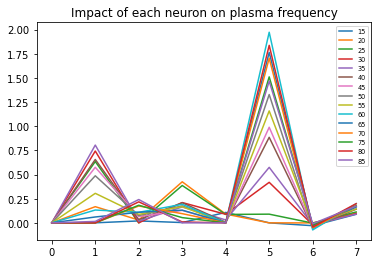

In [18]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])

fig, ax = plt.subplots()
ax.set_title("Impact of each neuron on plasma frequency")
for num in range(10,100,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        ax.plot(np.multiply(np.mean([pred_y[i] for i in index], axis=0),model.get_layer(name="dense_1").get_weights()[0][:,4]),label=num)
#ax.set_xscale(0,1)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.legend(prop={'size': 6.5})
plt.show()

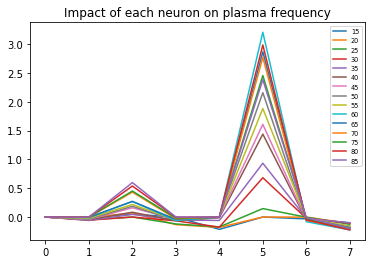

In [19]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])

fig, ax = plt.subplots()
ax.set_title("Impact of each neuron on plasma frequency")
for num in range(10,100,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        ax.plot(np.multiply(np.mean([pred_y[i] for i in index], axis=0),model.get_layer(name="dense_1").get_weights()[0][:,7]),label=num)
#ax.set_xscale(0,1)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.legend(prop={'size': 6.5})
plt.show()

In [20]:
# from the graphs above, neuron 5 seems consistently the most important neuron for determining plasma frequency

### Looking into 1st neuron

In [21]:
print(np.transpose(np.reshape(model.get_layer(name="dense").get_weights()[0][:,5],(10,16))))

[[-1.99983548e-02 -3.17132249e-02 -7.05654621e-02 -1.36643857e-01
  -4.52962816e-02  1.59561113e-01  2.50327945e-01  4.64660339e-02
  -4.03618068e-02 -2.01125257e-02]
 [-6.72690198e-02  5.95345974e-01 -8.23052025e+00 -2.44548035e+00
  -1.09068371e-01  1.66041240e-01  1.68326691e-01 -1.80146806e-02
  -5.31269871e-02 -1.45504577e-02]
 [ 5.00173010e-02 -1.04213402e-01 -6.69517040e-01 -2.90298867e+00
  -1.00561917e+00 -6.63957521e-02  5.14157712e-01  5.90761974e-02
  -1.81717664e-01  3.63433063e-02]
 [-1.59812301e-01 -1.36330590e-01  3.85718942e-01 -3.06379223e+00
  -1.15275884e+00  8.45054984e-02  3.05681974e-01  1.57838178e+00
   1.06617391e+00 -1.27360478e-01]
 [ 1.33872060e-02  3.80832195e-01  1.69287436e-02 -1.17753220e+00
  -1.49377406e+00 -3.35793868e-02  8.97229314e-01 -1.81897334e-03
  -2.26385351e-02 -7.22589731e-01]
 [ 3.65941972e-01 -2.50342824e-02  3.18781175e-02  1.92836940e-01
  -3.27828079e-02 -1.18620947e-01 -7.73159117e-02  3.88962403e-02
   2.19575725e-02 -3.47818853e-03

In [22]:
small_model = Sequential()
small_model.add(model.get_layer(name="conv1d"))
small_model.add(model.get_layer(name="max_pooling1d"))
small_model.add(model.get_layer(name="conv1d_1"))
small_model.add(model.get_layer(name="max_pooling1d_1"))
pred_y = small_model.predict(test_x_sorted)

14224/14224 [==============================] - 7s 503us/step


In [23]:
np.shape(pred_y)

(455153, 10, 16)

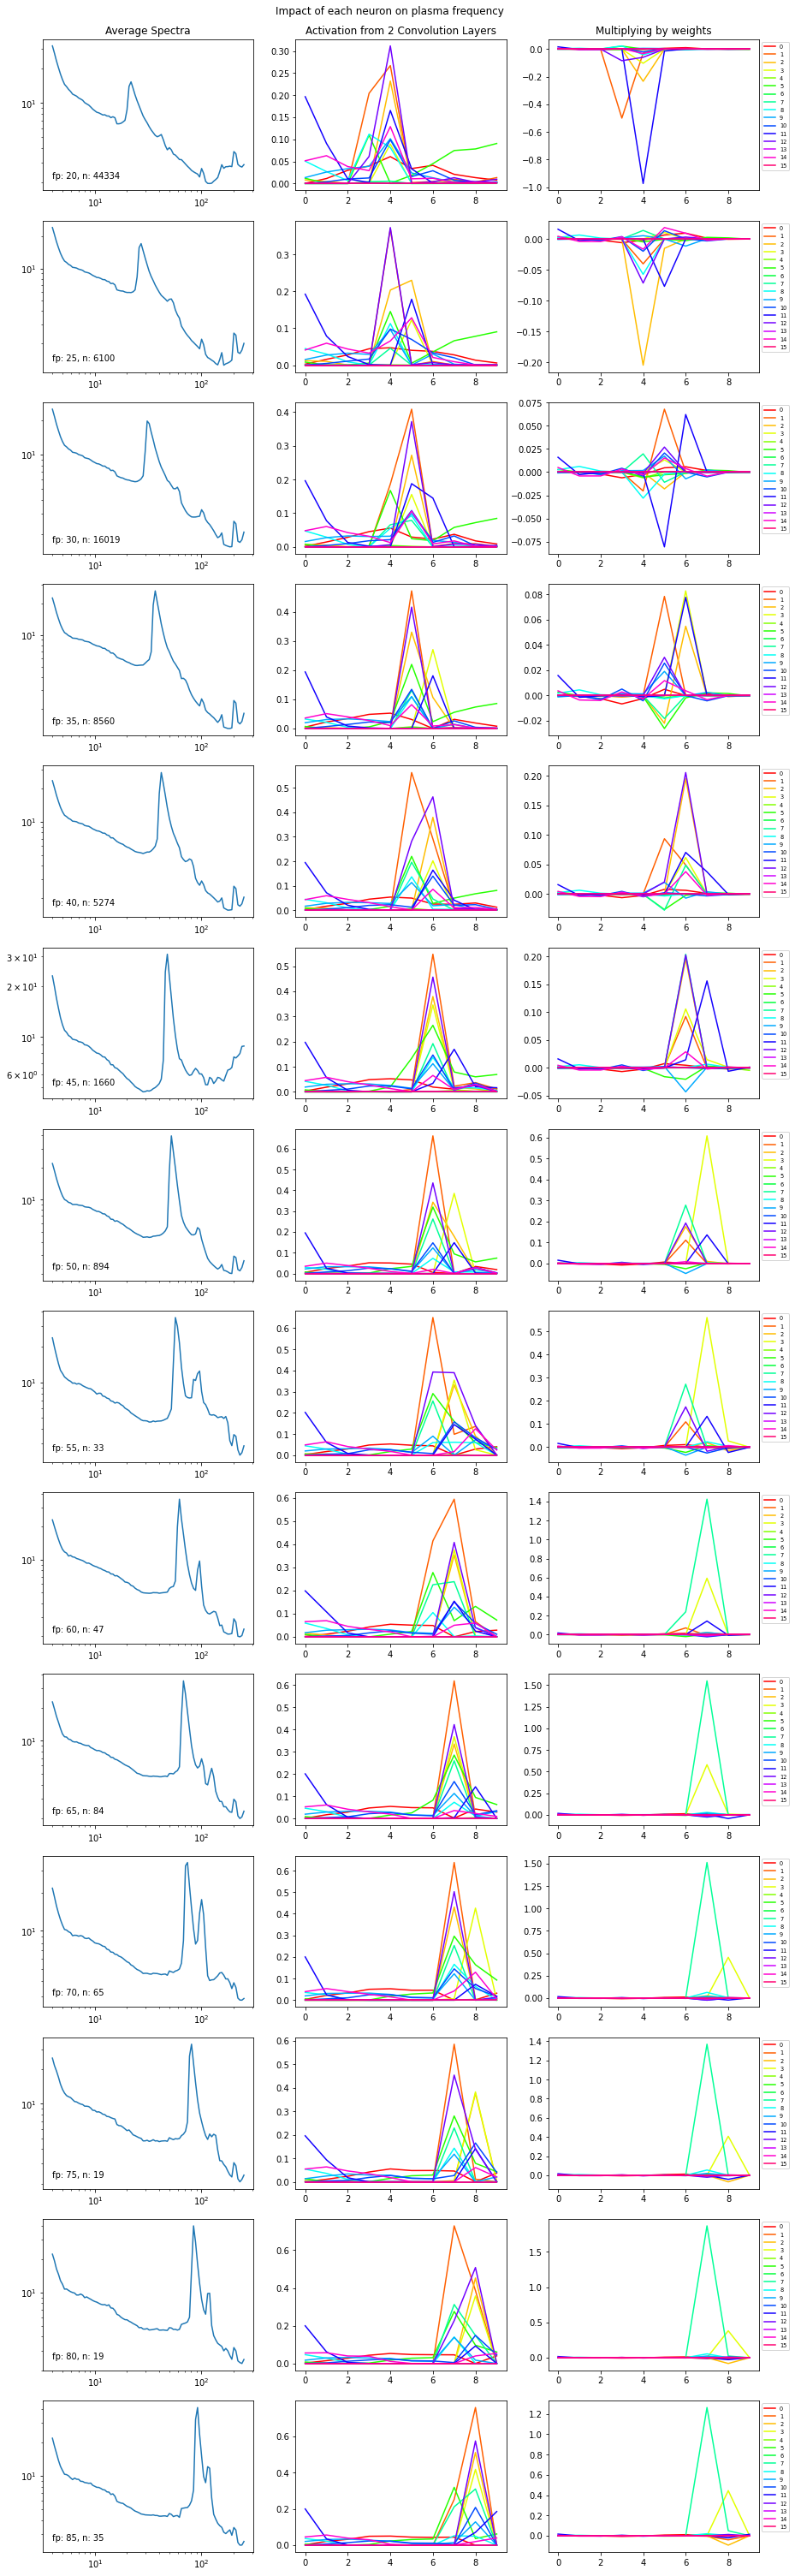

In [24]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])
weights = np.reshape(model.get_layer(name="dense").get_weights()[0][:,5],(10,16))

fig, ax = plt.subplots(70//5,3, figsize=(15,18*3))
fig.suptitle("Impact of each neuron on plasma frequency",y=.89)

for num in range(20,90,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        plot_array = np.multiply(np.mean([pred_y[i] for i in index], axis=0),weights)
        for i in range(16):
            ax[(num-20)//5,2].plot(plot_array[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/16))
        ax[(num-20)//5,2].legend(prop={'size': 6.5},bbox_to_anchor=(1,1), loc="upper left")

for num in range(20,90,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        plot_array = np.mean([pred_y[i] for i in index], axis=0)

        for i in range(16):
            ax[(num-20)//5,1].plot(plot_array[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/16))

for num in range(20,90,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        plot_array = np.mean([test_x_sorted[i] for i in index], axis=0)
        ax[(num-20)//5,0].plot(fbins/1000,plot_array*50)
        ax[(num-20)//5,0].set_xscale('log')
        ax[(num-20)//5,0].set_yscale('log')
        ax[(num-20)//5,0].text(min(fbins)/1000,1.1*min(plot_array*50), f"fp: {num}, n: {len(index)}")

ax[0,0].set_title("Average Spectra")
ax[0,1].set_title("Activation from 2 Convolution Layers")
ax[0,2].set_title("Multiplying by weights")
fig.savefig("plots/analysis_of_cnn_for_fpe.png")
plt.show()

In [25]:
# from the graphs above, neuron 5 seems consistently the most important neuron for determining plasma frequency

### Forward propogartion of the networks


In [26]:
model1 = Sequential()
model1.add(model.get_layer(name="conv1d"))

model2 = Sequential()
model2.add(model.get_layer(name="conv1d"))
model2.add(model.get_layer(name="max_pooling1d"))
model2.add(model.get_layer(name="conv1d_1"))

In [27]:
int_y_sorted = np.array([int(num*50) for num in test_y_sorted])
pred_y1 = model1.predict(test_x_sorted)
pred_y2 = model2.predict(test_x_sorted)

14224/14224 [==============================] - 7s 467us/step


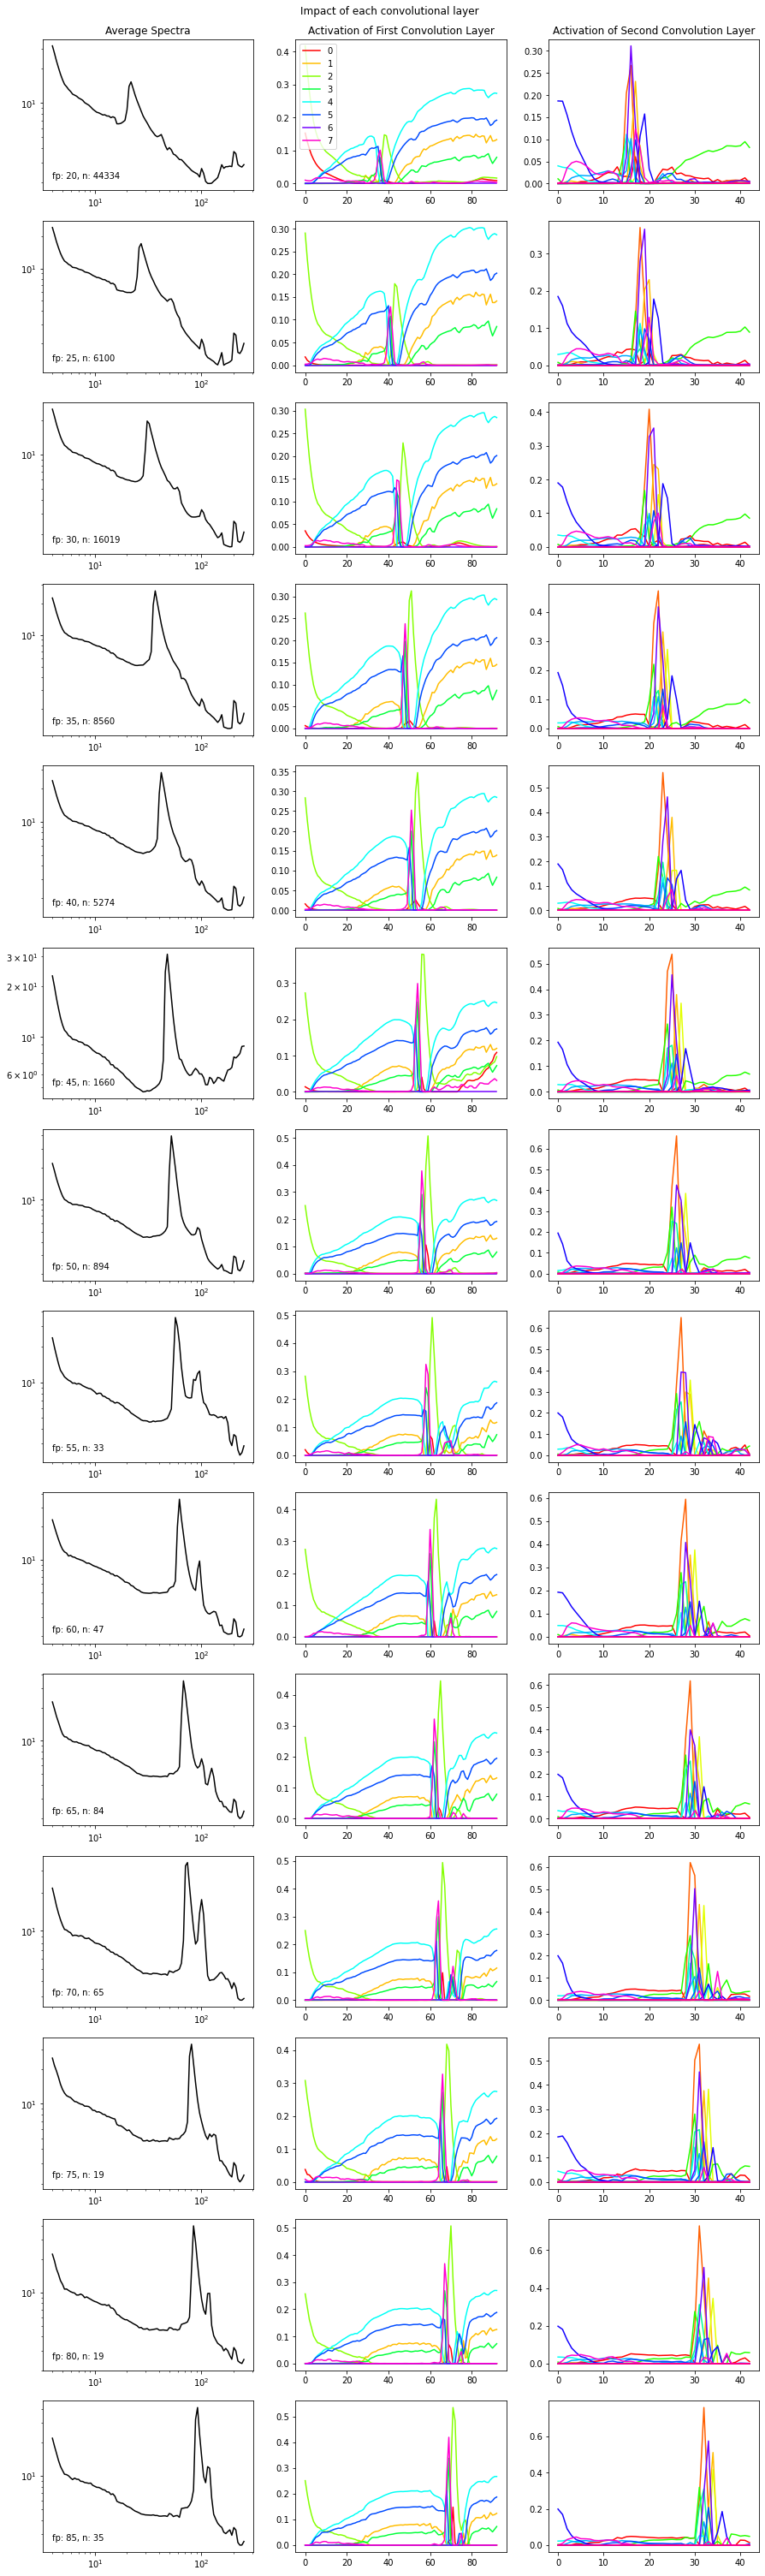

In [28]:
fig, ax = plt.subplots(70//5,3, figsize=(15,18*3))
fig.suptitle("Impact of each convolutional layer",y=.89)

for num in range(20,90,5):
    index = np.where(int_y_sorted == num)[0]

    if len(index)>0:
        
        plot_array = np.mean([test_x_sorted[i] for i in index], axis=0)
        ax[(num-20)//5,0].plot(fbins/1000, plot_array*50, color='black')
        
        ax[(num-20)//5,0].set_xscale('log')
        ax[(num-20)//5,0].set_yscale('log')
        
        ax[(num-20)//5,0].text(min(fbins)/1000,1.1*min(plot_array*50), f"fp: {num}, n: {len(index)}")

        plot_array1 = np.mean([pred_y1[i] for i in index], axis=0)
        plot_array2 = np.mean([pred_y2[i] for i in index], axis=0)

        for i in range(8):
            ax[(num-20)//5,1].plot(plot_array1[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/8))
        
        for i in range(16):
            ax[(num-20)//5,2].plot(plot_array2[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/16))
        #ax[(num-20)//5,1].legend(prop={'size': 6.5},bbox_to_anchor=(1,1), loc="upper left")


        #for i in range(16):
        #    ax[(num-20)//5,1].plot(plot_array[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/16))

ax[0,0].set_title("Average Spectra")
ax[0,1].set_title("Activation of First Convolution Layer")
ax[0,2].set_title("Activation of Second Convolution Layer")
ax[0,1].legend()
fig.savefig("plots/analysis_of_cnn_convolution_layers.png")
plt.show()

In [58]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

In [64]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the Axes.
    
    Call signatures::
    
        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)
    
    The call signatures correspond to the following different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    sele

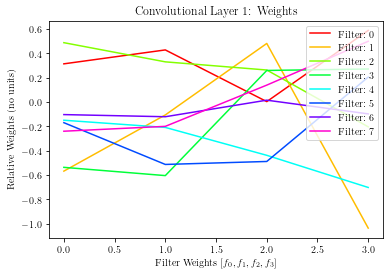

In [65]:
weights = np.transpose(model.get_layer(name="conv1d").get_weights()[0])
for i in range(8):
    plt.plot(weights[i,0], color=matplotlib.cm.get_cmap('hsv', 256)(i/8), label=f"Filter: {i}")
plt.rcParams['text.usetex'] = True
plt.title("Convolutional Layer 1: Weights")
plt.ylabel("Relative Weights (no units)")
plt.xlabel(r"Filter Weights [$f_0, f_1, f_2, f_3$]")
plt.legend(loc='upper right')
plt.savefig("plots/weights.png", dpi=500, facecolor='w')

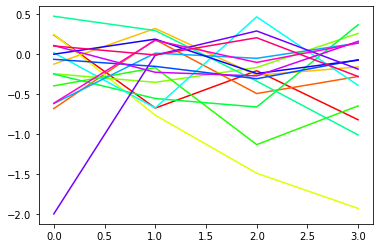

In [30]:
weights = np.transpose(model.get_layer(name="conv1d_1").get_weights()[0])
for i in range(16):
    plt.plot(weights[i,0], color=matplotlib.cm.get_cmap('hsv', 256)(i/16))
      

In [62]:
fig, ax = plt.subplots(1,4,figsize=(20,4), facecolor = 'w', dpi=1000)

num = 20
weights = np.reshape(model.get_layer(name="dense").get_weights()[0][:,5],(10,16))
index = np.where(int_y_sorted == num)[0]

plot_array = np.mean([test_x_sorted[i] for i in index], axis=0)
ax[0].plot(fbins/1000, plot_array*50, color='black')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].text(min(fbins)/1000,1.1*min(plot_array*50), f"fp: {num}, n: {len(index)}")

plot_array1 = np.mean([pred_y1[i] for i in index], axis=0)
plot_array2 = np.mean([pred_y2[i] for i in index], axis=0)

for i in range(8):
    ax[1].plot(plot_array1[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/8))

for i in range(16):
    ax[2].plot(plot_array2[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/16))

plot_array = np.multiply(np.mean([pred_y[i] for i in index], axis=0),weights)
for i in range(16):
    ax[3].plot(plot_array[:,i],label=i,color=matplotlib.cm.get_cmap('hsv', 256)(i/16))

ax[0].set_title("Average Spectra")
ax[1].set_title("Activation of Convolution Layer 1")
ax[2].set_title("Activation of Convolution Layer 2")
ax[3].set_title("Activation of Neuron Layer 1")
ax[1].set_ylabel(r"Relative Weight (no units)")
ax[2].set_ylabel(r"Relative Weight (no units)")
ax[3].set_ylabel(r"Relative Weight (no units)")
ax[0].set_ylabel(r"Fourier Transform Amplitude ($µV^2/Hz$)")
ax[0].set_xlabel(r"Frequency ($Hz^{-1}$)")
ax[1].set_xlabel(r"Layer 1 Output Vector")
ax[2].set_xlabel(r"Layer 2 Output Vector")
ax[3].set_xlabel(r"NN Layer 1 Output Vector")
fig.savefig("plots/analysis_of_cnn_convolution_layer_20fpe.png", dpi=1000)
plt.show()


In [32]:
np.transpose(model.get_layer(name="conv1d").get_weights()[0])


array([[[ 0.31338495,  0.42767903,  0.00307823,  0.58782494]],

       [[-0.5678272 , -0.10633404,  0.48087463, -1.0358253 ]],

       [[ 0.48718703,  0.32971868,  0.26262453, -0.20418182]],

       [[-0.5367917 , -0.60466295,  0.2590216 ,  0.2710243 ]],

       [[-0.14983238, -0.20886332, -0.4379712 , -0.7020851 ]],

       [[-0.16989516, -0.51298255, -0.4885375 ,  0.20463623]],

       [[-0.10347765, -0.12112621,  0.01495619, -0.09772629]],

       [[-0.24003646, -0.2001079 ,  0.13858984,  0.49874276]]],
      dtype=float32)

In [40]:
dir(fig)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_label_groups',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_button_pick_id',
 '_cachedRenderer',
 '_callbacks',
 '_canvas_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_constrained',
 '_constrained_layout_pads',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_get_draw_artists',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_localaxes',
 '_mouseover',
 '_normalize_grid_string',
 '_original_dpi',
 '_path_effects',
 '_picker',
 '_process_projection_r